[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Unsupervised learning with Autoencoder

We first play with MNIST dataset and pieces of code seen during the course.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

## Loading MNIST

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


In [4]:
# to be modified if not on colab
root_dir = '../data/MNIST/'
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

## Helper Functions

In [5]:
def to_img(x):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    The encoder is called by model.encoder
    The decoder is called by model.decoder
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

## Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [18]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [19]:
input_dim = 784
encoding_dim = 64

model = AutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

Why did we take 784 as input dimension?

To find the learning rate, see the documentation for [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [20]:
def train_model(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [21]:
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.127969
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.043933
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.032155
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.029592
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.024425
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.023497
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.022329
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.021298
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.019224
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.019297
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.019559
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.019215
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.017261
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.018469
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.017862
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.017595
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.017740
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.017287
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.017646
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.017031
Train Epoch: 6 [51200/60000 (85%)]	

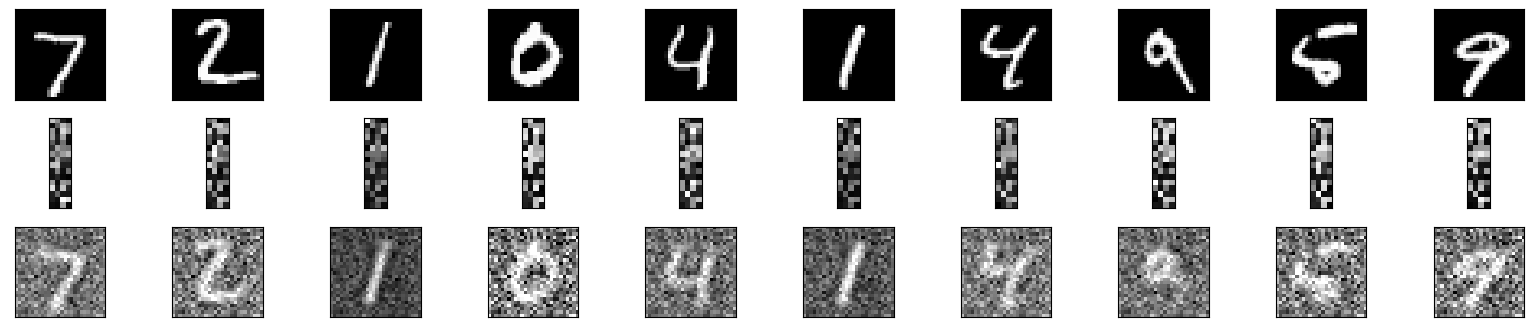

In [22]:
plot_reconstructions(model)

## 1. Exercise: Stacked Autoencoder

Now you will code an autoencoder where both the encoder and the decoder are multilayer perceptron (MLP). You can take for the encoder a first hidden layer with dimension 128, a second one with dimension 64 and then the code of dimension 32. For the decoder, you can take the same sequence of dimensions in reverse order.

In [84]:
class Encoder_Module(nn.Module):
    def __init__(self,input_dim, encoding_dim):
        super(Encoder_Module, self).__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=encoding_dim)

    def forward(self,x):
        y = self.fc1(x)
        y = F.relu(y)
        y = self.fc2(y)
        y = F.relu(y)
        y = self.fc3(y)
        return y #F.relu(y)

class Decoder_Module(nn.Module):
    def __init__(self,input_dim, encoding_dim):
        super(Decoder_Module, self).__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=encoding_dim)

    def forward(self,x):
        y = self.fc1(x)
        y = F.relu(y)
        y = self.fc2(y)
        y = F.relu(y)
        y = self.fc3(y)
        return y #F.relu(y)
    
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = Encoder_Module(input_dim, encoding_dim)
        self.decoder = Decoder_Module(encoding_dim, input_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [48]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()
#loss_fn = torch.nn.BCEWithLogitsLoss()
#loss_fn = torch.nn.CrossEntropyLoss()

In [49]:
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.109218
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.049855
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.038263
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.034290
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.030271
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.029436
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.029878
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.026888
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.025065
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.025830
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.023903
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.025162
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.024590
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.025262
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.023624
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.023746
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.022388
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.023122
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.023221
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.021585
Train Epoch: 6 [51200/60000 (85%)]	

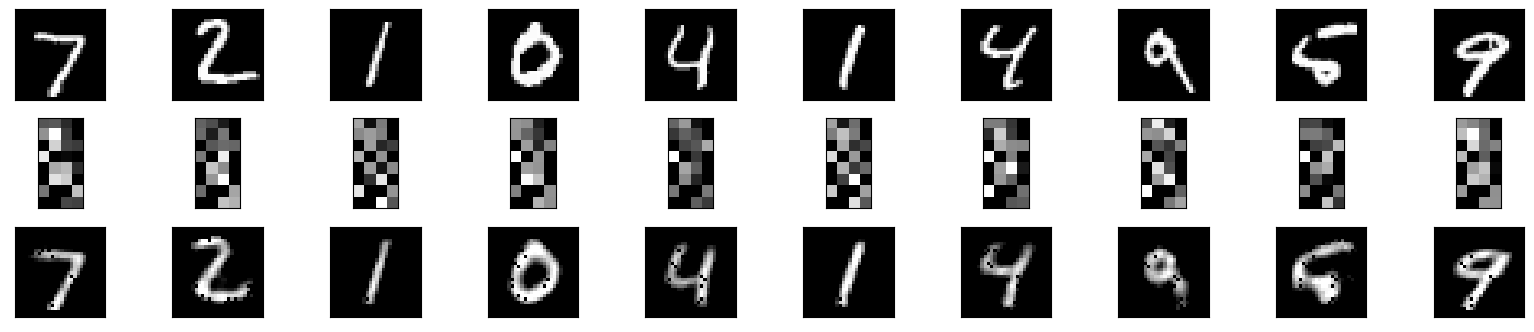

In [50]:
plot_reconstructions(model)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.117962
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.051684
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.037601
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.035398
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.031344
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.028093
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.027345
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.025734
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.024906
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.025561
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.024525
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.023008
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.022976
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.022271
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.022591
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.021189
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.021965
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.021418
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.020377
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.021100
Train Epoch: 6 [51200/60000 (85%)]	

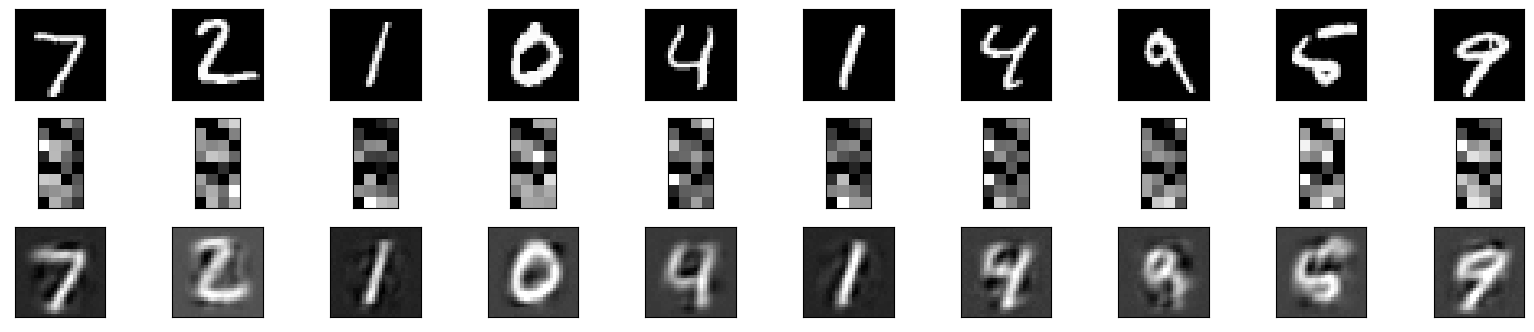

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.694266
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.262002
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.236318
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.231660
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.208285
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.201719
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.186683
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.165945
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.167715
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.162438
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.157825
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.150791
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.147238
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.138815
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.139936
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.151714
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.138216
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.137011
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.136191
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.133939
Train Epoch: 6 [51200/60000 (85%)]	

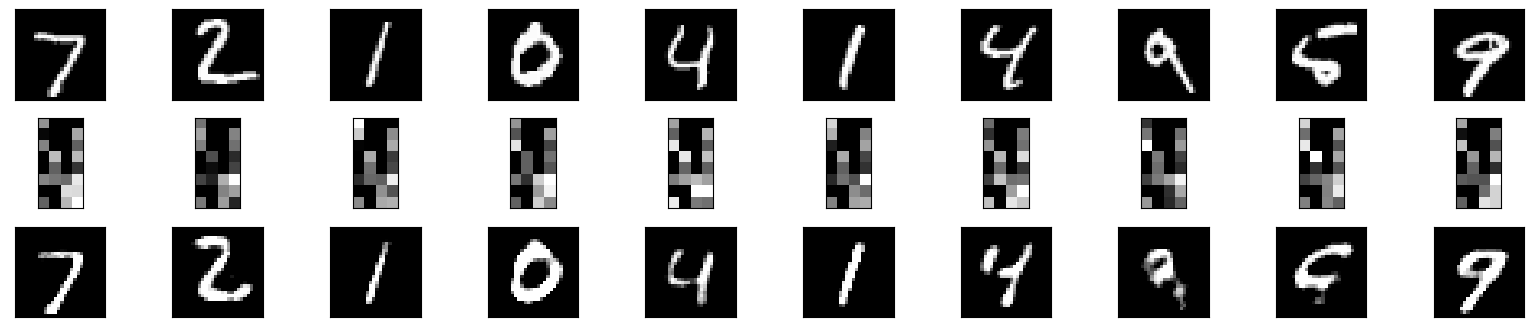

Train Epoch: 0 [0/60000 (0%)]	Loss: 683.232178
Train Epoch: 0 [25600/60000 (43%)]	Loss: 612.955872
Train Epoch: 0 [51200/60000 (85%)]	Loss: 553.308838
Train Epoch: 1 [0/60000 (0%)]	Loss: 554.309387
Train Epoch: 1 [25600/60000 (43%)]	Loss: 536.464111
Train Epoch: 1 [51200/60000 (85%)]	Loss: 550.632202
Train Epoch: 2 [0/60000 (0%)]	Loss: 539.950623
Train Epoch: 2 [25600/60000 (43%)]	Loss: 531.963257
Train Epoch: 2 [51200/60000 (85%)]	Loss: 525.902893
Train Epoch: 3 [0/60000 (0%)]	Loss: 519.863342
Train Epoch: 3 [25600/60000 (43%)]	Loss: 541.579773
Train Epoch: 3 [51200/60000 (85%)]	Loss: 523.015564
Train Epoch: 4 [0/60000 (0%)]	Loss: 558.678711
Train Epoch: 4 [25600/60000 (43%)]	Loss: 540.087524
Train Epoch: 4 [51200/60000 (85%)]	Loss: 533.807251
Train Epoch: 5 [0/60000 (0%)]	Loss: 537.464661
Train Epoch: 5 [25600/60000 (43%)]	Loss: 547.161011
Train Epoch: 5 [51200/60000 (85%)]	Loss: 538.807251
Train Epoch: 6 [0/60000 (0%)]	Loss: 529.288330
Train Epoch: 6 [25600/60000 (43%)]	Loss: 515.63

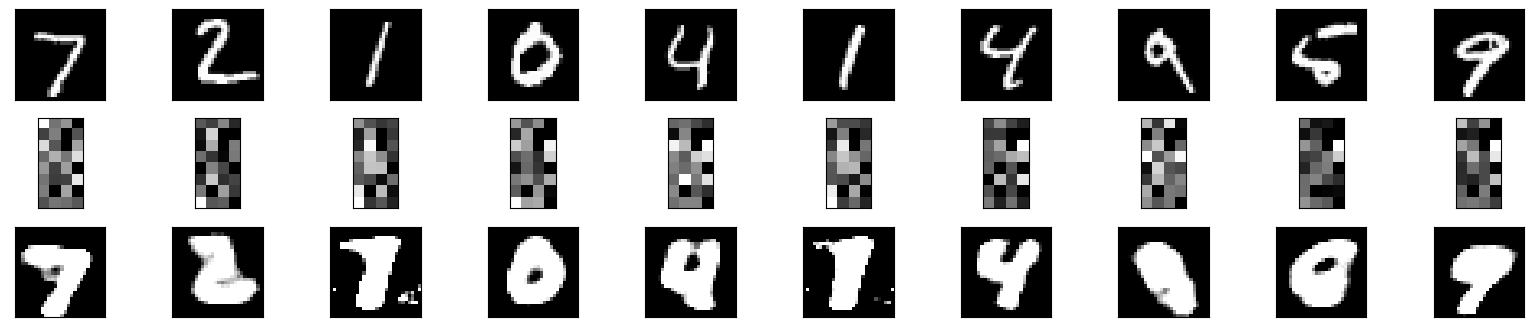

In [55]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)
plot_reconstructions(model)

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
#loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.BCEWithLogitsLoss()
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)
plot_reconstructions(model)

Replace the `MSELoss` with a `BCEWithLogitsLoss` for each pixel. Note the unusual use of `BCEWithLogitsLoss`! You can have a look at the definition of [Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy).

## 2. Optional

At this stage, you can code the interpolation described in the lesson to obtain:

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/interp_AE.png)

In [ ]:
N = 10
alpha = np.linspace(0,1,10)


# 3. Exercise: Implement a denoising AE:


Use previous code and with minimal modifications, transform your AE in a denoising AE. Now, you first apply some noise to your input and try to recover the original data at the output. For the noise, you can add some random noise or erase some of the pixels. In this last case, you should obtain something like: 

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/denoising_AE.png)

The first line corresponds to the original digit, the second line to the noisy version of the digit given as input to your network, the third line is the associated code and the last line is the denoised digit obtained by your decoder from the code.

In [107]:
# You need first to modify the training process by adding noise to your data
# Hint if you want to erase pixels: https://stackoverflow.com/questions/49216615/is-there-an-efficient-way-to-create-a-random-bit-mask-in-pytorch
def train_denoiser(model,loss_fn,data_loader=None,epochs=1,optimizer=None, noise=0.1):
    model.train()
    for epoch in range(epochs):
      for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view([-1, 784]).to(device)
        #noisy_data = data+(torch.rand_like(data)-.5)*1
        #noisy_data = data*torch.rand_like(data)*2
        noisy_data = data*torch.randint_like(data,0,2)

        optimizer.zero_grad()
        output = model(noisy_data)
        loss = loss_fn(output, data)
        loss.backward()
        optimizer.step()
            
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))

In [108]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [109]:
train_denoiser(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer, noise=0.8)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.692976
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.262481
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.243801
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.237035
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.226505
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.193290
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.187884
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.172284
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.162920
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.157978
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.154462
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.148874
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.147688
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.148329
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.141782
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.151685
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.143388
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.135055
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.142132
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.141328
Train Epoch: 6 [51200/60000 (85%)]	

In [110]:
# Now you need to modify the plot function
def plot_denoising(model, noise=0.1):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, , the second row is the noisy digits, 
    the third row is the encoded vector and
    the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784]).to(device)
    #noisy_data = data*torch.rand_like(data)*2
    noisy_data = data*torch.randint_like(data,0,2)

    encoded_imgs = model.encoder(noisy_data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display code
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

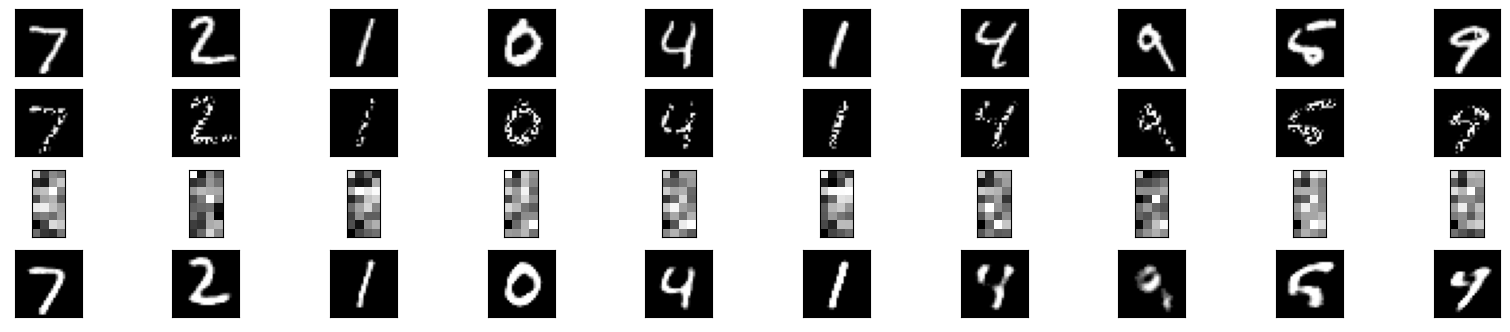

In [111]:
plot_denoising(model,noise=0.8)

# 4. Optional: how to deal with convolutions?

Hint: start by decreasing the size of your image with `Conv2d` by using a `stride` like:

In [112]:
conv = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2)
x = torch.randn(2, 8, 64, 64)
y = conv(x)
y.shape

torch.Size([2, 16, 32, 32])

Now use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (or [deconvolution](https://distill.pub/2016/deconv-checkerboard/)) with the same parameters:

In [ ]:
convt = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, padding=1, stride=2)

In [ ]:
convt(y).shape

To get the same size as `x`, play with `output_padding`.

Now, you have all the tools to build a convolutional autoencoder!

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)